In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [6]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3-4b-pt",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)


model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,               # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

==((====))==  Unsloth 2025.7.11: Fast Gemma3 patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


In [8]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

import os
from PIL import Image
from datasets import Dataset


from unsloth import get_chat_template

processor = get_chat_template(
    processor,
    "gemma-3"
)

In [12]:
import os
from PIL import Image
from datasets import Dataset


dataset_folder = "/kaggle/input/visionnetworkgemmini1/dataset"
data_samples = []
image_files = sorted([f for f in os.listdir(dataset_folder) if f.endswith(".png")])



for image_file in image_files:

    base_name = os.path.splitext(image_file)[0]
    image_path = os.path.join(dataset_folder, image_file)
    text_path = os.path.join(dataset_folder, f"{base_name}.txt")


    if os.path.exists(image_path) and os.path.exists(text_path):
        
        
        try:
            with open(text_path, "r", encoding="utf-8") as f:
                text_content = f.read().strip()
                
            image_obj = Image.open(image_path).convert("RGB")

            data_samples.append({
                "image": image_obj,
                "text": text_content
            })
        except Exception as e:
            print(f"Error processing {base_name}: {e}")
    else:
        print(f"Warning: Missing paired file for {base_name}. Skipping.")



raw_dataset = Dataset.from_list(data_samples)
print(f"Created a dataset with {len(raw_dataset)} samples.")
print(raw_dataset[0]) 


instruction = "You are a Cisco Packet Tracer networking expert. Analyze the provided networking image and answer questions about its components, topology. Provide clear and concise explanations."

def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["text"]}]},
    ]
    return {"messages": conversation}
pass




converted_dataset = [convert_to_conversation(sample) for sample in raw_dataset]
print(converted_dataset[0])


import random
random.seed(42) 
random.shuffle(converted_dataset)


from unsloth import get_chat_template

processor = get_chat_template(
    processor,
    "gemma-3"
)

Created a dataset with 534 samples.
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=347x303 at 0x7D2CABDB0F10>, 'text': 'switch: \n    - Switch0 (Model: 2950-24)'}
{'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'You are a Cisco Packet Tracer networking expert. Analyze the provided networking image and answer questions about its components, topology. Provide clear and concise explanations.'}, {'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=347x303 at 0x7D2C9056EE90>}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'switch: \n    - Switch0 (Model: 2950-24)'}]}]}


In [14]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) 

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor),
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = True,

        # use reentrant checkpointing
        gradient_checkpointing_kwargs = {"use_reentrant": False},
        max_grad_norm = 0.3,              # max gradient norm based on QLoRA paper
        warmup_ratio = 0.03,
        #max_steps = 30,
        num_train_epochs = 3,          # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 20,
        save_strategy="steps",
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",             # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "messages",
        dataset_kwargs = {"skip_prepare_dataset": True},
    )
)

trainer_stats = trainer.train()
model.save_pretrained("LastManith01")  
processor.save_pretrained("LastManith01")

Unsloth: Switching to float32 training since model cannot work with float16


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 534 | Num Epochs = 3 | Total steps = 201
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 38,497,792 of 4,338,577,264 (0.89% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
20,0.911500
40,0.092400
60,0.083800
80,0.060000
100,0.064100
120,0.058700
140,0.059900
160,0.047200
180,0.050900
200,0.048700


['LastManith01/processor_config.json']

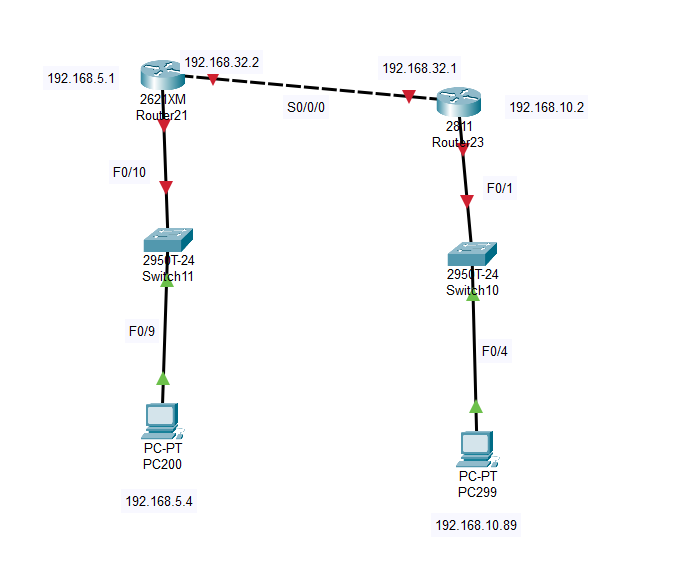

In [3]:
from PIL import Image
from IPython.display import display

test_image = Image.open("/kaggle/input/visionnetworkgemmini1/dataset/523.png")
display(test_image)

In [15]:
test_image = Image.open("/kaggle/input/test123/test.png").convert("RGB")
FastVisionModel.for_inference(model) 

# image = raw_dataset[10]["image"]
image = test_image

instruction = "You are a Cisco Packet Tracer networking expert. Analyze the provided networking image and answer questions about its components, topology. Provide clear and concise explanations."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 600,
                        use_cache=True, temperature = 0.5, top_p = 0.95, top_k = 30)

Switch:
    - Switch23 (Model: 2950T-24)
    - Connected to PC0 (F0/12)
    - Connected to PC1 (F0/13)
    - Connected to Switch10 (Dashed Line)

Switch:
    - Switch10 (Model: 2950T-24)
    - Connected to PC2 (F0/10)
    - Connected to PC3 (F0/9)
    - Connected to Switch23 (Dashed Line)

PC:
    - PC0 (Model: PC-PT, IP: 192.168.1.100)
    - Connected to Switch23 (Dashed Line)

PC:
    - PC1 (Model: PC-PT, IP: 192.168.1.120)
    - Connected to Switch23 (Dashed Line)

PC:
    - PC2 (Model: PC-PT, IP: 192.168.1.121)
    - Connected to Switch10 (Dashed Line)

PC:
    - PC3 (Model: PC-PT, IP: 192.168.1.148)
    - Connected to Switch10 (Dashed Line)<end_of_turn>


In [4]:
from transformers import TextStreamer
import unsloth
test_image = Image.open("/kaggle/input/visionnetworkgemmini1/dataset/523.png").convert("RGB")

if True:

    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/kaggle/working/LastManith01",
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    
    FastLanguageModel.for_inference(model)

image = test_image
instruction = "You are a Cisco Packet Tracer networking expert. Analyze the provided networking image and answer questions about its components, topology. Provide clear and concise explanations."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]


input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")





text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 600,
                        use_cache=True, temperature = 0.5, top_p = 0.95, top_k = 30)

/tmp/ipykernel_36/1964422547.py:6: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-08-07 09:52:40.474054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754560360.649586      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754560360.697711      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


NameError: name 'max_seq_length' is not defined

In [ ]:
from PIL import Image
from transformers import TextStreamer

# Load image
test_image_2 = Image.open("/kaggle/input/test123/test.png").convert("RGB")
test_image = Image.open("/kaggle/input/visionnetworkgemmini1/dataset/521.png")
FastVisionModel.for_inference(model) 

image = test_image

instruction = "You are a Cisco Packet Tracer networking expert. Analyze the provided networking image and answer questions about its components, topology. Provide clear and concise explanations."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]

# Prepare inputs
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

# --- Custom streamer to capture text ---
class SaveTextStreamer(TextStreamer):
    def __init__(self, tokenizer, skip_prompt=True):
        super().__init__(tokenizer, skip_prompt=skip_prompt)
        self.generated_text = ""

    def on_finalized_text(self, text: str, stream_end: bool = False):
        self.generated_text += text
        super().on_finalized_text(text, stream_end)

# Use our custom streamer
text_streamer = SaveTextStreamer(processor, skip_prompt=True)

# Generate
model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=600,
    use_cache=True,
    temperature=0.5,
    top_p=0.95,
    top_k=30
)

# Now you can access the full result
generated_text = text_streamer.generated_text
print("\n\n--- Final Captured Output ---\n")
print(generated_text)

In [18]:
generated_text

'Switch:\n    - Switch10 (Model: 2950T-24)\n    - Connected to PC1 (F0/1)\n    - Connected to PC3 (F0/9)\n    - Connected to Switch23 (Dashed Line)\n\nSwitch:\n    - Switch23 (Model: 2950T-24)\n    - Connected to PC0 (F0/12)\n    - Connected to PC2 (F0/10)\n    - Connected to Switch10 (Dashed Line)\n\nPC:\n    - PC1 (Model: PC-PT, IP: 192.168.1.120)\n    - Connected to Switch10\n\nPC:\n    - PC3 (Model: PC-PT, IP: 192.168.1.148)\n    - Connected to Switch10\n\nPC:\n    - PC0 (Model: PC-PT, IP: 192.168.1.100)\n    - Connected to Switch23\n\nPC:\n    - PC2 (Model: PC-PT, IP: 192.168.1.121)\n    - Connected to Switch23<end_of_turn>'